# Using ICA and PCA to Predict Infection Counts

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA, PCA

import warnings
warnings.filterwarnings("ignore") # to avoid complex number warning

#### Load in the data and prepare for analysis

In [13]:
from create_datasets import SymptomDiseaseData
data = SymptomDiseaseData()
train, valid, test, train_labels, valid_labels, test_labels = data.generate_data(split=True)
data.get_data_insight()

Symptom's shape: (890, 18)
Disease's shape: (890, 3)
Symptoms at index 0:
 [ 0 10  0  0  0  0  0  3  0  2  1  0  0  0  0  0  1  0]
Disease at index 0:
 [  7   0 136]


In [14]:
# Restack valid and test cause we don't need them
test = np.vstack((valid, test))
test_labels = np.vstack((valid_labels, test_labels))

#### Compute ICs and fit

In [15]:
ica = FastICA(n_components=train_labels.shape[1])#, whiten=False)
S_ = ica.fit_transform(train)  # Reconstruct signals

#### Compute PCs and fit, as well as eigenvalues

In [16]:
pca = PCA(n_components=train_labels.shape[1], whiten=False)
pca_done = pca.fit_transform(train)

In [17]:
cov = pca.get_covariance()
eig = np.linalg.eig(cov)

## Results
ICA did not return a good model of the data, but PCA seemed to create a good match.  We then plotted the eigenvalues to see how well they were describing the data, and saw that the first principal compenent accounted for much of the data.  

We then decided to cut out the first principle component to examine things further.

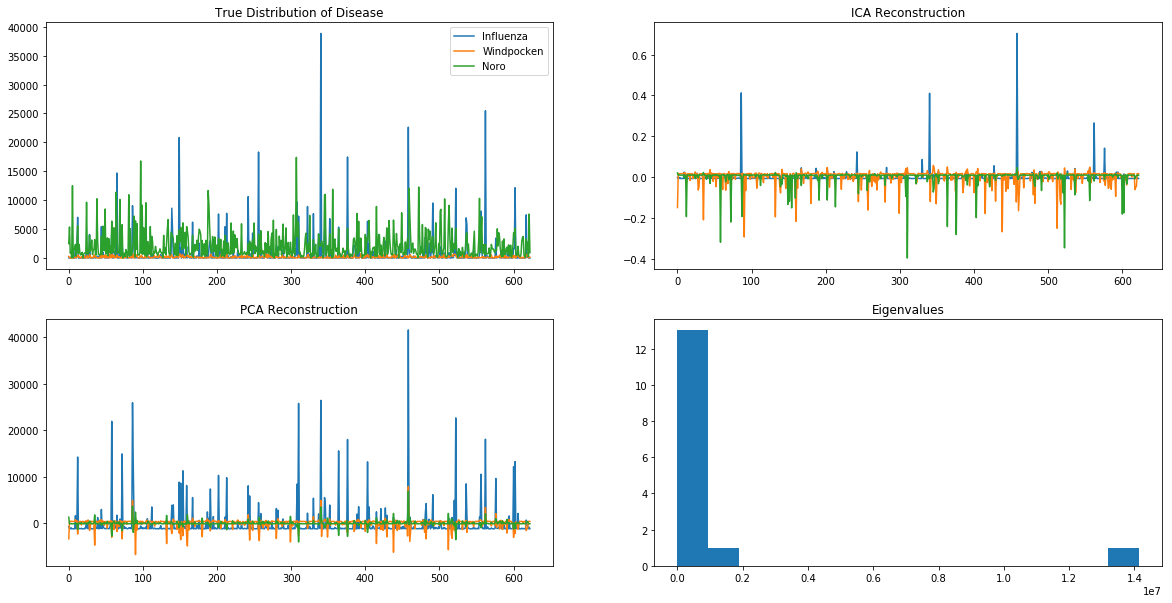

In [35]:
bottom = 250
top = 350
zoom = False

f, axarr = plt.subplots(2, 2, figsize=(20, 10))
f.size=((20,20))

axarr[0, 0].plot(train_labels.T[0], label='Influenza')
axarr[0, 0].plot(train_labels.T[1], label='Windpocken')
axarr[0, 0].plot(train_labels.T[2], label='Noro')
if zoom: axarr[0, 0].set_xlim([bottom,top])
axarr[0, 0].legend()
axarr[0, 0].set_title('True Distribution of Disease')

axarr[0, 1].plot(S_)
if zoom: axarr[0, 1].set_xlim([bottom,top])
axarr[0, 1].set_title('ICA Reconstruction')

axarr[1, 0].plot(pca_done)
if zoom: axarr[1, 0].set_xlim([bottom,top])
axarr[1, 0].set_title('PCA Reconstruction')

axarr[1, 1].hist(eig[0][:15], bins=15)
axarr[1, 1].set_title('Eigenvalues')

plt.show()

Now it is time to test the PC representation on unseen data to see if it can reconstruct it.

In [25]:
pca_test = pca.transform(test)
error = test_labels - pca_test

Now plot:

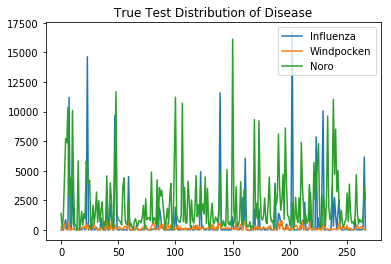

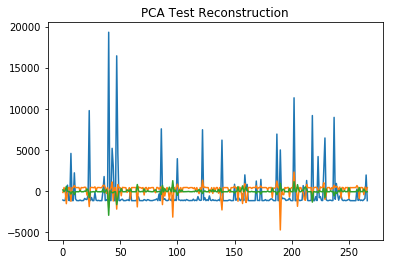

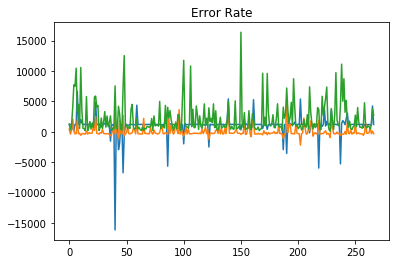

In [33]:
fig = plt.figure()
fig.size=((20,20))

plt.plot(test_labels.T[0], label='Influenza')
plt.plot(test_labels.T[1], label='Windpocken')
plt.plot(test_labels.T[2], label='Noro')
# if zoom: axarr[0, 0].set_xlim([bottom,top])
plt.legend()
plt.title('True Test Distribution of Disease')
plt.show()

plt.plot(pca_test)
# if zoom: axarr[0, 1].set_xlim([bottom,top])
plt.title('PCA Test Reconstruction')
plt.show()

plt.plot(error)
# if zoom: axarr[1, 0].set_xlim([bottom,top])
plt.title('Error Rate')
plt.show()

plt.show()

Upon further thought, we realized PCA and other such algorithms don't work with time series data.  When tested with the full dataset, the fit wasn't too bad, but we believe it was because it learned that at Week 40, spike Influenza.  When destroying the time dependency via splitting the data randomly, PCA fails to find any pattern.  Also, because of this dependency, we doubt future data will fit even if we "trained" the PCA on the full dataset.

# Further Work:
We saw extreme periodicity in the disease data, so we figured why not throw an LSTM at it!